# Product 1 (see next page)

![](BeaverRiverWatershed.png "Title")

# Product 2

Text(0.5, 1.0, 'Estimated Baseflow with Minimum Discharge in ft^3 per second vs time')

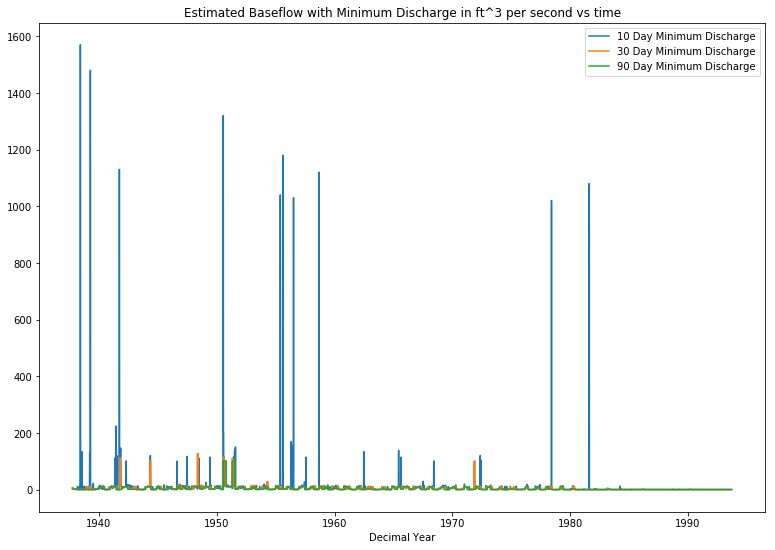

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import xlrd
from datetime import datetime as dt
import time

discharge_df = pd.read_csv('discharge.txt', skiprows=27, sep='\t')\
    .drop(0, axis=0).rename(columns={'111434_00060_00003':\
            'discharge (ft^3/sec)','111434_00060_00003_cd':'code' })

discharge_df['datetime'] = pd.to_datetime(discharge_df['datetime'])

def toYearFraction(date):
    """
    https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years
    """
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

discharge_df['Decimal Year'] = discharge_df['datetime']\
    .apply(lambda x: toYearFraction(x))
discharge_df = discharge_df.set_index('datetime')

#http://benalexkeen.com/resampling-time-series-data-with-pandas/
discharge_df['10 Day Minimum Discharge'] = \
    discharge_df['discharge (ft^3/sec)'].resample('10D')\
    .min().resample('1D').ffill().astype(float)

discharge_df['30 Day Minimum Discharge'] = \
    discharge_df['discharge (ft^3/sec)'].resample('30D')\
    .min().resample('1D').ffill().astype(float)

discharge_df['90 Day Minimum Discharge'] = \
    discharge_df['discharge (ft^3/sec)'].resample('90D')\
    .min().resample('1D').ffill().astype(float)

discharge_df['discharge (ft^3/sec)'] = \
    discharge_df['discharge (ft^3/sec)'].astype(float)

discharge_df.plot(x='Decimal Year',
    y=['10 Day Minimum Discharge',
       '30 Day Minimum Discharge',
       '90 Day Minimum Discharge'], 
                  figsize=(13,9))
plt.title("Estimated Baseflow with Minimum Discharge in ft^3 per second vs time")

In [4]:
yearly_discharge = pd.DataFrame()
yearly_discharge['10 Day Minimum Discharge 2 Year Rolling Mean'] =\
    discharge_df['10 Day Minimum Discharge'].resample('1Y')\
    .sum().rolling(window=2).mean()
yearly_discharge['30 Day Minimum Discharge 2 Year Rolling Mean'] =\
    discharge_df['30 Day Minimum Discharge'].resample('1Y')\
    .sum().rolling(window=2).mean()
yearly_discharge['90 Day Minimum Discharge 2 Year Rolling Mean'] =\
    discharge_df['90 Day Minimum Discharge'].resample('1Y')\
    .sum().rolling(window=2).mean()

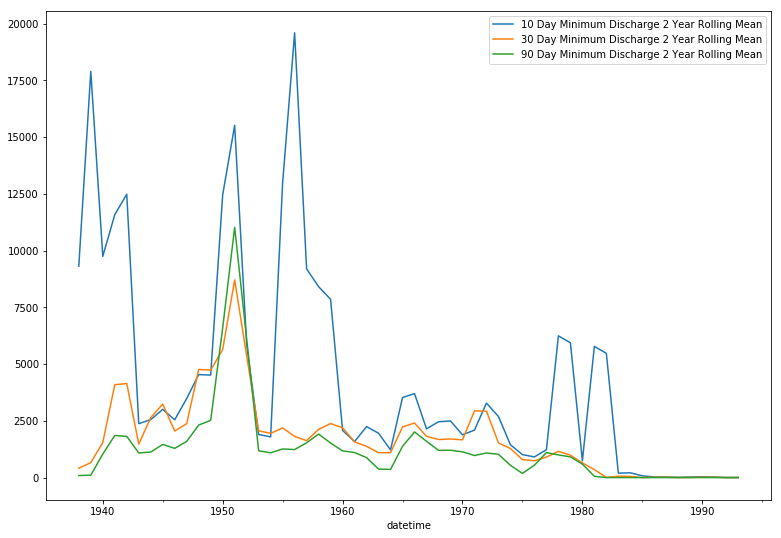

In [108]:
yearly_discharge.plot(y=['10 Day Minimum Discharge 2 Year Rolling Mean',\
        '30 Day Minimum Discharge 2 Year Rolling Mean',\
        '90 Day Minimum Discharge 2 Year Rolling Mean'], figsize=(13,9))

# Product 3

Our baseflow estimates show that baseflow was overall much higher the earlier in the time series you examine. There is a considerable drop off in the baseflow estimation no matter what resampling window is used that really gets going around 1970 all the way through 1990 and the end of the data record. Periodic drought signals are clearly apparent throughout the time series where there are large declines in the baseflow estimate, particularly around 1964, 1954, and 1945. These are spaced roughly equally apart which might indicate there is some climate system that causes this (like ENSO?). The trends for each of the resampling intervals show that a larger resampling window will result in lower baseflow estimates because the larger window will capture more lower minimum flows than a smaller window, causing larger minimum flows to be masked out of the resulting estimate.

# Product 4

In [6]:
gw_levels = pd.read_csv("gwlevels.csv", skiprows=81, sep='\t')\
    .drop(0, axis=0).drop(['site_tp_cd', 'lev_tm', \
        'lev_tz_cd', 'sl_lev_va', 'sl_datum_cd', 'lev_status_cd',\
        'lev_agency_cd'], axis=1)
gw_levels = gw_levels.rename(columns={'lev_va':'Water level, \
    feet below land surface', 'lev_dt':'Date'})

gw_levels['datetime'] = pd.to_datetime(gw_levels['Date'])
gw_levels['Decimal Year'] = gw_levels['datetime']\
    .apply(lambda x: toYearFraction(x))
gw_levels['Water level, feet below land surface'] = \
    gw_levels['Water level, feet below land surface'].astype(float)

Elevation of the Well Water

In [114]:
gw_levels['Well Water Elevation (Hydraulic Head ft)'] = \
    gw_levels['Water level, feet below land surface']\
    .apply(lambda x: 3430 - x)
gw_levels['Difference between well water level and river level'] = \
    gw_levels['Water level, feet below land surface']\
    .apply(lambda x: 3430 - x - 3230)
gw_levels.head(5)

,agency_cd,site_no,Date,"Water level, feet below land surface",lev_dt_acy_cd,lev_acy_cd,lev_src_cd,lev_meth_cd,lev_age_cd,Decimal Year,Well Water Elevation (Hydraulic Head),Difference between well water level and river level,Well Water Elevation (Hydraulic Head ft)
datetime,,,,,,,,,,,,,
1956-07-26,USGS,363033101440701,1956-07-26,188.95,D,2,U,S,A,1956.565460,3241.05,11.05,3241.05
1956-08-05,USGS,363033101440701,1956-08-05,189.03,D,2,U,B,A,1956.592782,3240.97,10.97,3240.97
1956-08-10,USGS,363033101440701,1956-08-10,189.03,D,2,U,B,A,1956.606444,3240.97,10.97,3240.97
1956-08-15,USGS,363033101440701,1956-08-15,189.02,D,2,U,B,A,1956.620105,3240.98,10.98,3240.98
1956-08-20,USGS,363033101440701,1956-08-20,189.09,D,2,U,B,A,1956.633766,3240.91,10.91,3240.91


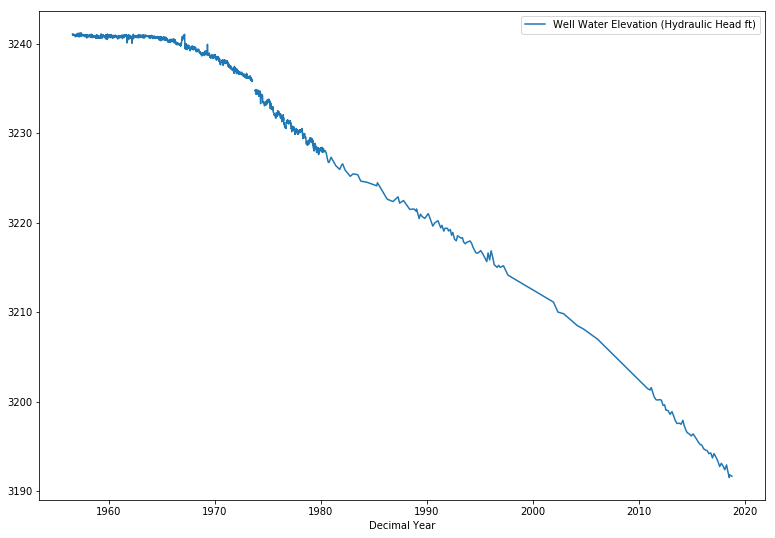

In [115]:
gw_levels.plot(x = 'Decimal Year', 
    y='Well Water Elevation (Hydraulic Head ft)', figsize=(13, 9))

# Product 5

The groundwater level in the well have steadily declined in the monitoring well. It's not a completely linear pattern, from about 1955 until about 1975 the decline seemed to follow an exponential decay pattern. After the mid 1970s the decline seems to follow a linear pattern.

Rate of Change from 1960 until 1970

In [9]:
gw_levels = gw_levels.set_index('datetime')

In [10]:
gw_levels_1960_1970 = gw_levels['1960-01-01':'1970-12-31']
gw_levels_1980_1990 = gw_levels['1980-01-01':'1990-12-31']

In [11]:
(gw_levels_1980_1990['Well Water Elevation (Hydraulic Head)'].iloc[-1] - \
 gw_levels_1980_1990['Well Water Elevation (Hydraulic Head)'].iloc[0]) / \
(gw_levels_1980_1990['Decimal Year'].iloc[-1] - \
 gw_levels_1980_1990['Decimal Year'].iloc[0])

-0.7714218532423462

In [14]:
(gw_levels_1960_1970['Well Water Elevation (Hydraulic Head)'].iloc[-1] - \
 gw_levels_1960_1970['Well Water Elevation (Hydraulic Head)'].iloc[0]) / \
(gw_levels_1960_1970['Decimal Year'].iloc[-1] - \
 gw_levels_1960_1970['Decimal Year'].iloc[0])

-0.2594132580754109

From 1960 to present day, groundwater levels have declined 50 feet. There is also considerable microvariations in the trend, with some stretches of time experiencing small scale noise (<1960-1980), less considerable noise (1980-~1995) and verry little noise (1995-~2010). This could be due to differences in instrumental error with time, judging by the abrupt changes in these small scale patterns with time. From 1980 to 1990 the absolute averaged change is a decrease of .7714 feet per each decimal year. From 1960 to 1970 the absolute rate of change was a decrease of .2594 feet per each decimal year. From 1960 - 1970 the rate of depletion (the slope) is not so steep but seems to be becoming more severe over time (at 1960, and the next few years after there does not seem to be much depletion ocurring). Then from 1980-1990 the slope is near constant and severe, with depletion ocurring at a constant rate along this time period. Comparing this to our graphs of the rolling 2 year averages of minimum discharge (our estimate of baseflow) we see that there are fewer and less intense peaks of baseflow estimates later in the time series than earlier before 1960. Possibly this is because depletion removed enough ground water from the near sub-surface so that much less is flushed out during rain events due to pressure from infiltrating precipitation water, and because the water table has declined to where it isn't as effected by infiltrating precipitation.

## Part 4 Streamflow Depletion

In [15]:
beaver_df = pd.ExcelFile("streamflow_depletion_to_class.xlsx").parse()

flowlines = gpd.read_file('beaver_gis/BeaverRiverFlowlines.shp')
constructed_wells = gpd.read_file('beaver_gis/ConstructedWells.shp')

well_flowline_distances = constructed_wells\
    .distance(flowlines['geometry'].iloc[0])

beaver_df = beaver_df.iloc[0:1702,:]
beaver_df['Distance  from the well to the stream (m)'] = \
    well_flowline_distances
beaver_df['WellID'] = constructed_wells['WellID']

In [53]:
x_arr = beaver_df.to_xarray()

In [56]:
from scipy.special import erfc

def streamflow_by_near_distance(pumping_rate, dist_to_stream, \
            specific_yield, transmissivity, t_constant_pumping):
    
    """Adapted from excel equation 
    =IF(ISNUMBER(B2),
    D2*ERFC(SQRT(B2*B2*E2/(4*H2*(C2*24*60*60)))),
    "")
    distance to stream should be in meters
    pumping rate should be m^3 per second
    t_constant_pumping is in days out of the year
    specific yield is dimensionless
    transmissivity is m^2/second
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfc.html
    """
    
    return pumping_rate*erfc(\
        np.sqrt(\
            dist_to_stream*dist_to_stream*specific_yield/\
               (4*transmissivity*(t_constant_pumping*24*60*60))))

streamflow_depletion_meters = streamflow_by_near_distance(x_arr['Pumping rate (m3/s)'], 
        x_arr['Distance  from the well to the stream (m)'],
        x_arr['Storativity or specific yield of aquifer: "S" (dimensionless)'],
        x_arr['Transmissivity of aquifer (m2/s)'], 
        x_arr['Time of constant pumping (days)'])
    

beaver_df['Streamflow depletion (m3/s)'] = streamflow_depletion_meters

beaver_df['Streamflow depletion (ft3/s)'] = \
    streamflow_depletion_meters*35.3147 #conversion to ft cubed

# Product 6

Text(0.5, 1.0, 'Depletion vs Distance from Well to Flowline (365 days of constant pumping)')

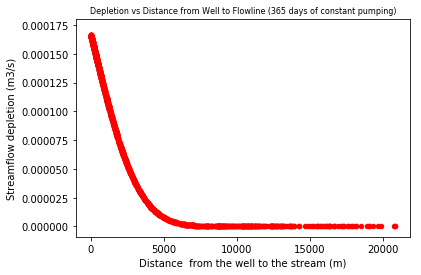

In [102]:
beaver_df.plot.scatter(x='Distance  from the well to the stream (m)', 
                y='Streamflow depletion (m3/s)', color='r')
plt.ylim(-.000009,.00018)
plt.title('Depletion vs Distance from Well to Flowline (365 days of constant pumping)', size=8)

In [97]:
streamflow_depletion_meters_3650 = streamflow_by_near_distance(x_arr['Pumping rate (m3/s)'], 
        x_arr['Distance  from the well to the stream (m)'],
        x_arr['Storativity or specific yield of aquifer: "S" (dimensionless)'],
        x_arr['Transmissivity of aquifer (m2/s)'], 
        len(x_arr['Time of constant pumping (days)'])*3650)
    
beaver_df_3650 = beaver_df.copy()
beaver_df_3650['Streamflow depletion (m3/s)'] = streamflow_depletion_meters_3650

beaver_df_3650['Streamflow depletion (ft3/s)'] = \
    streamflow_depletion_meters_3650*35.3147 #conversion to ft cubed

Text(0.5, 1.0, 'Depletion vs Distance from Well to Flowline (3650 days of constant pumping)')

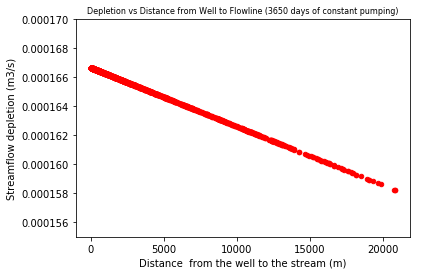

In [101]:
beaver_df_3650.plot.scatter(x='Distance  from the well to the stream (m)', 
                y='Streamflow depletion (m3/s)', color='r')
plt.ylim(.000155,.00017)
plt.title('Depletion vs Distance from Well to Flowline (3650 days of constant pumping)', size=8)

In [104]:
(beaver_df['Streamflow depletion (m3/s)']/\
    beaver_df['Streamflow depletion (m3/s)'].sum()).max()

0.0013463234451614454

In [105]:
(beaver_df_3650['Streamflow depletion (m3/s)']/\
    beaver_df_3650['Streamflow depletion (m3/s)'].sum()).max()

0.0005928107510510149

# Product 7


The relationship between distance from well to stream and streamflow depletion is one of exponential decay for the 365 day of constant pumping model (under the assumptions of the model we used, which assumes constant subsurface properties for all wells and equal pumping rate, to name a few of them). With this model, the wells closest to the stream have the most outsized impact on depletion. Nearly all (more than 90%) of the depletion contribution is estimated to be within 5000 meters of the stream.

For the longer pumping interval, the relationship is linear decay. Closer wells still have a disproportionate impact on streamflow depletion, but compared to wells farter away they don't have as outsize a contribution to depletion, because the longer time interval of constant pumping gives wells farther away more time to "catch up" and deplete streamflow from GW withdrawls. This is probably because the model is accounting for the fact that over longer time scales, pumping farther away from the stream will lead to less lateral redistribution of water through the aquifer to areas that are farther away, whereas on shorter time scales this is not as much of a factor for wells that are greater than 5000 meters or so away from the nearest flowline.

The maximum streamflow depletion percentage any one well is responsible for is .1346%, under the constant pumping for 365 days scenario. The problem with managing groundwater withdrawals is that even though they are point sources and relatively easier to identify than non point sources, there are so many point sources under different levels and boundaries of ownership and oversight that it is extremely complicated and controversial to implement policy to limit pumping withdrawals. Yet the connections between subsurface and surface water don't obey the neat jurisdicitional boundaries set by policies like SGMA, and furthermore we don't have a great understanding of the vertical and horizontal characteristics of these connections to begin with. This means that watersheds need to be managed to limit small point sources of depletion that are far away (greater than a few miles) yet too often they are not. Over large time scales, this will probably have disastrous results and we are witnessing the beginnings of these with dry wells, saltwater intrusion, subsidence, etc.